In [208]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils

In [317]:
families = maf.archive.get_family_descriptions()
family_list = families.index.values
summary_source = 'summary_2022_08_01.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metrics_source = 'metric_sets.json'
metric_set = maf.get_metric_sets(metrics_source)
msets = metric_set.groupby('metric set').first().index.to_list()

In [318]:
families.loc[['microsurveys']].explode(['run', 'brief']).query('run.str.contains("too")')[['run', 'brief']]

,run,brief
family,,
microsurveys,too_rate10_v2.0_10yrs,"Follow up ToO alerts, 10 events per year"
microsurveys,too_rate50_v2.0_10yrs,"Follow up ToO alerts, 50 events per year"


In [319]:
baseline_run = 'baseline_v2.0_10yrs'
these_runs = np.concatenate([[baseline_run], 
                             families.explode('run').query('run.str.contains("too")')['run'].to_list()])
these_runs

array(['baseline_v2.0_10yrs', 'too_rate10_v2.0_10yrs',
       'too_rate50_v2.0_10yrs'], dtype='<U21')

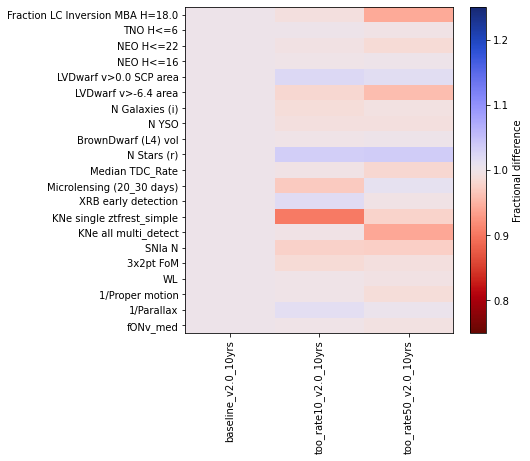

In [320]:
msub = metric_set.loc['SCOC'].query('not metric.str.contains("TDE")')

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']],
                               baseline_run=baseline_run, 
                               metric_set=msub,
                                   metric_label_map=msub['short_name'],
                           #horizontal_quantity='run',
                           #vertical_quantity='value',
                             color_range=.5
                             )

(<Figure size 576x540 with 1 Axes>, <RadarAxesSubplot:>)

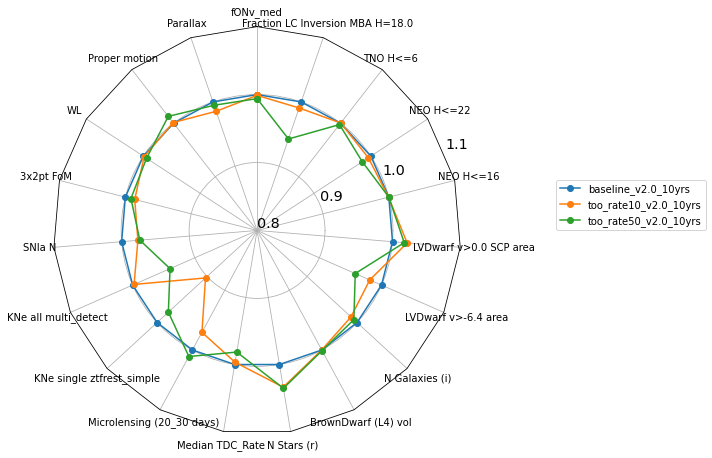

In [100]:
df = maf.normalize_metric_summaries('baseline_v2.0_10yrs', summaries.loc[these_runs, msub['metric']])
df.rename(columns=msub['short_name'], inplace=True)
maf.radar(df,
         rgrids=[0.8, 0.9, 1.0, 1.1,],
         figsize=(8, 7.5))

In [104]:
opsdb = '/Users/lynnej/opsim/v2.0/too_rate10_v2.0_10yrs.db'
runName = os.path.split(opsdb)[-1].replace('.db', '')

sql = 'note like "%ToO%"'
m1 = maf.CountMetric(col='observationStartMJD', metricName='Nvisits')
s = maf.HealpixSlicer(nside=64)

s2 = maf.OneDSlicer(sliceColName='night', binsize=1)

b1 = maf.MetricBundle(m1, s, sql, runName=runName)
b2 = maf.MetricBundle(m1, s2, sql, runName=runName)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [128]:
g = maf.MetricBundleGroup({'sky': b1, 'night': b2}, opsdb, outDir='tmp')
g.runAll()

Querying table None with constraint note like "%ToO%" for columns ['fieldDec', 'rotSkyPos', 'observationStartMJD', 'fieldRA', 'night']
Found 13039 visits
Running:  ['sky']
Completed metric generation.
Running:  ['night']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


In [132]:
opsdba = '/Users/lynnej/opsim/v2.0/too_rate50_v2.0_10yrs.db'
runNamea = os.path.split(opsdb)[-1].replace('.db', '')

sql = 'note like "%ToO%"'
m1 = maf.CountMetric(col='observationStartMJD', metricName='Nvisits')
sa = maf.HealpixSlicer(nside=64)

s2a = maf.OneDSlicer(sliceColName='night', binsize=1)

b1a = maf.MetricBundle(m1, sa, sql, runName=runNamea)
b2a = maf.MetricBundle(m1, s2a, sql, runName=runNamea)

ga = maf.MetricBundleGroup({'sky': b1a, 'night': b2a}, opsdba, outDir='tmp')
ga.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying table None with constraint note like "%ToO%" for columns ['fieldDec', 'rotSkyPos', 'observationStartMJD', 'fieldRA', 'night']
Found 56877 visits
Running:  ['sky']
Completed metric generation.
Running:  ['night']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


1

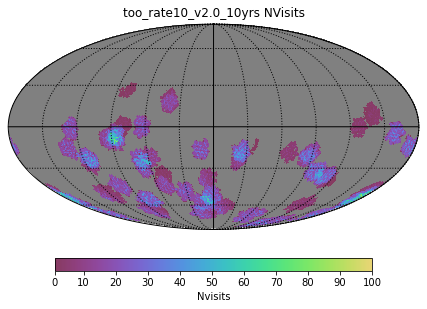

In [141]:
ph = maf.PlotHandler(outDir='tmp', thumbnail=False)
ph.setMetricBundles([b1])
ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'title': f'{runName} NVisits',
                                                 'xlabel': "Nvisits",
                                                 'colorMax': 100}
                                                 )

1

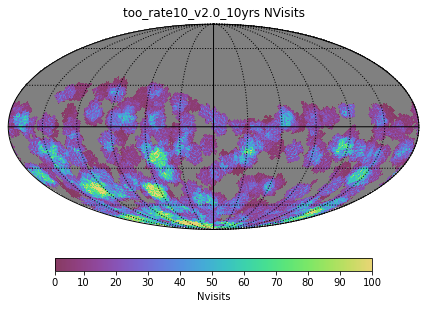

In [142]:
ph = maf.PlotHandler(outDir='tmp', thumbnail=False)
ph.setMetricBundles([b1a])
ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'title': f'{runName} NVisits',
                                     'xlabel': "Nvisits",
                                                'colorMax': 100})

Text(0, 0.5, 'N ToO visits')

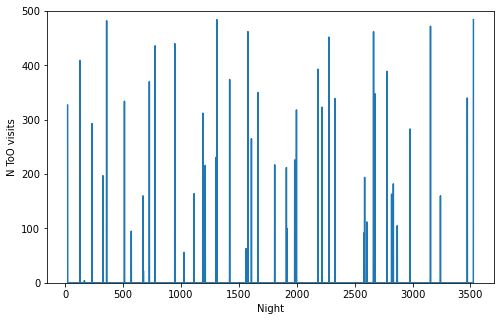

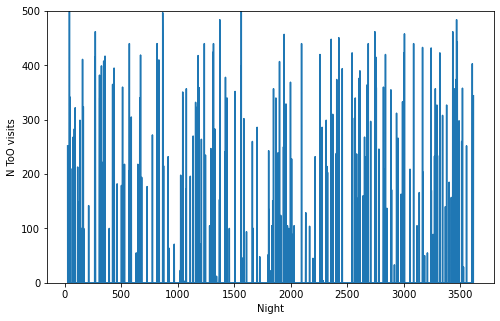

In [140]:
plt.figure(figsize=(8,5))
plt.plot(s2.bins[:-1], b2.metricValues.filled(0))
plt.ylim(0, 500)
plt.xlabel("Night")
plt.ylabel("N ToO visits")

plt.figure(figsize=(8,5))
plt.plot(s2a.bins[:-1], b2a.metricValues.filled(0))
plt.ylim(0, 500)
plt.xlabel("Night")
plt.ylabel("N ToO visits")

In [149]:
cols = ['fieldRA', 'fieldDec', 'filter', 'rotSkyPos', 'observationStartMJD', 'fiveSigmaDepth', 'night', 'note']
sqlconstraint = 'note like "%ToO%"'

simdata = maf.getSimData(opsdb, sqlconstraint, cols)
simdataa = maf.getSimData(opsdba, sqlconstraint, cols)

In [225]:
# Event info
import sqlite3 
conn = sqlite3.connect(opsdb)
too10 = pd.read_sql('select * from events', conn)
conn.close()

conn = sqlite3.connect(opsdba)
too50 = pd.read_sql('select * from events', conn)
conn.close()

print(len(too10), len(too50))

100 500
6.281411396119178


In [202]:
np.where(too10['mjd_start'].diff() < too10['mjd_start'].diff().min() + 0.01)
too10.iloc[19:21]

,index,mjd_start,ra,dec,expires
19,19,60787.769986,3.388787,-0.773225,60790.769986
20,20,60787.858084,5.073296,-0.320695,60790.858084


In [222]:
too50.iloc[5]

index            5.000000
mjd_start    60259.469188
ra               1.021752
dec             -0.323162
expires      60262.469188
Name: 5, dtype: float64

In [206]:
pd.DataFrame(simdata[np.where((simdata['observationStartMJD'] > 60787) & (simdata['observationStartMJD'] < 60791))])

,fieldRA,fieldDec,filter,rotSkyPos,observationStartMJD,fiveSigmaDepth,night,note
0,284.148776,-20.683282,r,113.569539,60788.219342,23.323264,570,"ToO, 20_t8"
1,285.406974,-18.127698,r,115.042997,60788.219788,23.259312,570,"ToO, 20_t8"
2,286.254890,-23.074492,r,112.465568,60788.220237,23.301859,570,"ToO, 20_t8"
3,286.640612,-15.577313,r,116.364117,60788.220690,23.193424,570,"ToO, 20_t8"
4,287.497419,-20.481477,r,114.001140,60788.221139,23.178045,570,"ToO, 20_t8"
...,...,...,...,...,...,...,...,...
90,293.202342,-14.876284,y,116.833827,60788.266533,21.640233,570,"ToO, 20_t8"
91,294.168795,-19.691752,y,113.556691,60788.266982,21.692414,570,"ToO, 20_t8"
92,295.317263,-16.988738,y,115.404425,60788.267428,21.777064,570,"ToO, 20_t8"
93,296.342928,-21.836308,y,112.204146,60788.267878,21.807978,570,"ToO, 20_t8"


In [157]:
print(len(simdata), len(simdataa))
#print(summaries.loc[these_runs, 'Nvisits All visits'])
print(len(simdata)/summaries.loc['too_rate10_v2.0_10yrs', 'Nvisits All visits'] * 100)
print(len(simdataa)/summaries.loc['too_rate50_v2.0_10yrs', 'Nvisits All visits'] * 100)

13039 56877
0.6249970041941283
2.7344856150681567


In [172]:
d = pd.DataFrame(simdataa)
d.groupby('night')['note'].unique()

night
26           [ToO, 2_t1, ToO, 2_t2, ToO, 2_t4, ToO, 2_t8]
41                      [ToO, 4_t0, ToO, 4_t1, ToO, 4_t2]
42      [ToO, 5_t0, ToO, 5_t1, ToO, 5_t2, ToO, 5_t4, T...
45           [ToO, 6_t0, ToO, 6_t1, ToO, 6_t2, ToO, 6_t4]
53           [ToO, 7_t0, ToO, 7_t1, ToO, 7_t2, ToO, 7_t4]
                              ...                        
3527                                        [ToO, 482_t8]
3554              [ToO, 489_t2, ToO, 489_t4, ToO, 489_t8]
3604                           [ToO, 495_t4, ToO, 495_t8]
3605    [ToO, 496_t0, ToO, 496_t1, ToO, 496_t2, ToO, 4...
3616    [ToO, 497_t0, ToO, 497_t1, ToO, 497_t2, ToO, 4...
Name: note, Length: 226, dtype: object

In [226]:
dd = d.query('night==42').sort_values(by='observationStartMJD')
xx, yy = rsUtils.gnomonic_project_toxy(np.radians(dd['fieldRA']), 
                                      np.radians(dd['fieldDec']), 
                                      too50.iloc[5].ra, 
                                      too50.iloc[5].dec)
xx = np.degrees(xx)
yy = np.degrees(yy)
dd

,fieldRA,fieldDec,filter,rotSkyPos,observationStartMJD,fiveSigmaDepth,night,note
259,50.286405,-18.970820,r,114.803075,60260.008577,23.133211,42,"ToO, 5_t0"
260,51.393051,-16.339610,r,116.096908,60260.009023,23.053254,42,"ToO, 5_t0"
261,52.430887,-21.382681,r,113.811165,60260.009472,23.134277,42,"ToO, 5_t0"
262,53.524252,-18.758823,r,115.175937,60260.009918,22.965421,42,"ToO, 5_t0"
263,54.566042,-16.130049,r,116.390668,60260.010364,22.861271,42,"ToO, 5_t0"
...,...,...,...,...,...,...,...,...
753,61.908407,-12.822685,y,240.094740,60260.354510,21.585394,42,"ToO, 5_t8"
754,62.381271,-20.311568,y,246.970337,60260.354975,21.644515,42,"ToO, 5_t8"
755,63.310408,-17.658044,y,244.262025,60260.355421,21.622216,42,"ToO, 5_t8"
756,64.215604,-15.013571,y,241.603676,60260.355867,21.697670,42,"ToO, 5_t8"


(-15.0, 15.0)

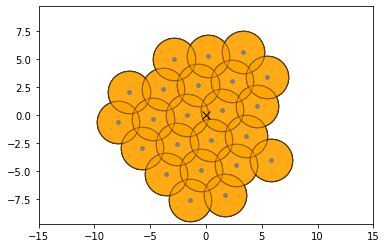

In [256]:
fig,ax = plt.subplots()
ax.axis('equal')
# These are just the center of the pointings - replace with patches
#plt.plot(x, y, 'k.')
# Might be able to do a hack?
#plt.scatter([0], [0], s=10000, 
#            #marker='o', markersize=100, linestyle=''
#            edgecolor='black', facecolor='red', alpha=0.2)
plt.scatter(xx, yy, s=1800, 
            #marker='o', markersize=100, linestyle=''
            edgecolor='black', facecolor='orange', alpha=0.1)
plt.plot(xx, yy, marker='.', markersize=5, linestyle='', color='gray')
plt.plot([0], [0], marker='x', markersize=8, linestyle='', color='k')
#plt.scatter([0], [0], s=1800, color='gray')
#plt.axhline(1.75)
plt.xlim(-15, 15)
plt.ylim(-15, 15)

In [310]:
dd.groupby(['note', 'fieldRA', 'fieldDec'])['filter'].unique()

note       fieldRA    fieldDec  
ToO, 5_t0  50.286405  -18.970820          [r, g, i]
           51.393051  -16.339610          [r, g, i]
           52.430887  -21.382681          [r, g, i]
           53.524252  -18.758823          [r, g, i]
           54.566042  -16.130049          [r, g, i]
                                         ...       
ToO, 5_t8  61.908407  -12.822685    [r, g, i, u, y]
           62.381271  -20.311568    [r, g, i, u, y]
           63.310408  -17.658044    [r, g, i, u, y]
           64.215604  -15.013571    [r, g, i, u, y]
           64.783362  -22.454009    [r, g, i, u, y]
Name: filter, Length: 115, dtype: object

In [314]:
dd.groupby(['note'])['filter'].unique() #.count()

note
ToO, 5_t0          [r, g, i]
ToO, 5_t1       [r, g, i, u]
ToO, 5_t2    [r, g, i, u, y]
ToO, 5_t4    [i, u, y, g, r]
ToO, 5_t8    [r, g, i, u, y]
Name: filter, dtype: object

In [295]:
dd.query('fieldRA > 61.9084069 and fieldRA < 61.908408')#['observationStartMJD'].diff() * 24 * 60

,fieldRA,fieldDec,filter,rotSkyPos,observationStartMJD,fiveSigmaDepth,night,note
285,61.908407,-12.822685,r,117.823789,60260.021673,23.065284,42,"ToO, 5_t0"
300,61.908407,-12.822685,r,117.698958,60260.029443,23.386086,42,"ToO, 5_t1"
323,61.908407,-12.822685,r,117.627874,60260.040382,23.381790,42,"ToO, 5_t2"
346,61.908407,-12.822685,g,117.705466,60260.052669,24.018663,42,"ToO, 5_t0"
369,61.908407,-12.822685,g,117.932218,60260.063700,24.305043,42,"ToO, 5_t1"
392,61.908407,-12.822685,g,118.329447,60260.074787,24.494252,42,"ToO, 5_t2"
415,61.908407,-12.822685,i,119.009970,60260.087247,23.688826,42,"ToO, 5_t0"
438,61.908407,-12.822685,i,119.875627,60260.098498,23.702258,42,"ToO, 5_t1"
461,61.908407,-12.822685,i,121.040320,60260.109854,23.813958,42,"ToO, 5_t2"
484,61.908407,-12.822685,i,122.580740,60260.121335,23.722941,42,"ToO, 5_t4"


Text(0, 0.5, '"x"')

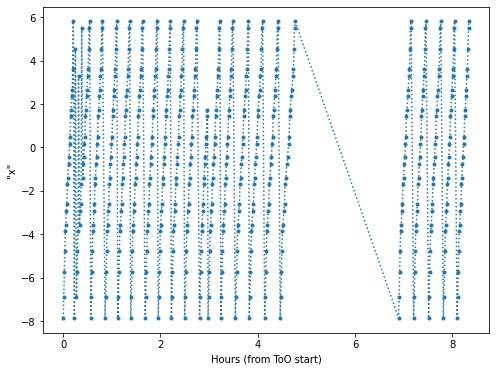

In [316]:
tt = dd['observationStartMJD'] -  dd['observationStartMJD'].min()
hrs = tt * 24
plt.figure(figsize=(8, 6))
plt.plot(hrs, xx, linestyle=':', marker='.') 
#plt.plot(hrs, np.sqrt(xx**2 + yy**2), linestyle=':', marker='.')
plt.xlabel("Hours (from ToO start)")
plt.ylabel('"x"')